In [1]:
from pyspark.sql import SparkSession

app = SparkSession.builder \
    .appName("CHURN DATA ANALYSIS") \
    .config("spark.jars", "/path/to/mysql-connector-java-8.0.33.jar") \
    .getOrCreate()

In [11]:
host_name = "localhost"
port_number = 3306
database_name = "churn_prediction"
url = f"jdbc:mysql://{host_name}:{port_number}/{database_name}"

In [14]:
connection_properties = {

                           "user":"root",
                           "password":"easwari",
                           "driver":"com.mysql.cj.jdbc.Driver"
}

In [12]:
table1 = "customers"

In [15]:
try:
    customers_df = app.read.jdbc(url=url, table=table1, properties=connection_properties)
    customers_df.show()
except Exception as e:
    print(f"error as {e}")

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+---------------+--------------+-----+--------------------+---------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|numAdminTickets|numTechTickets|Churn|     tenure_category| Loyality|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------

In [16]:
customers_df.createOrReplaceTempView("customers")

In [86]:
result1 = app.sql('''
                      select count(customerID) as `Total_no_of_customers`,
                      (select count(customerID) from customers where Churn = 'Yes') as `Total_no_of_churned_customers`,
                      (select count(customerID) from customers where Churn = 'No') as `Total_no_of_retained_customers` 
                      from customers
                  ''')
result1.show()

+---------------------+-----------------------------+------------------------------+
|Total_no_of_customers|Total_no_of_churned_customers|Total_no_of_retained_customers|
+---------------------+-----------------------------+------------------------------+
|                 7032|                         1869|                          5163|
+---------------------+-----------------------------+------------------------------+



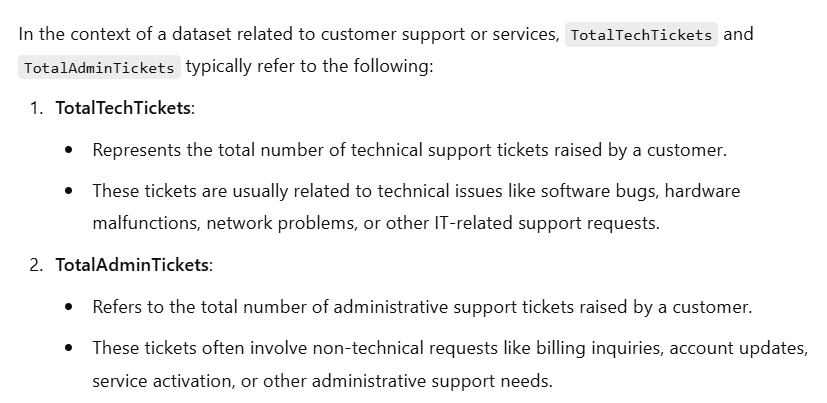

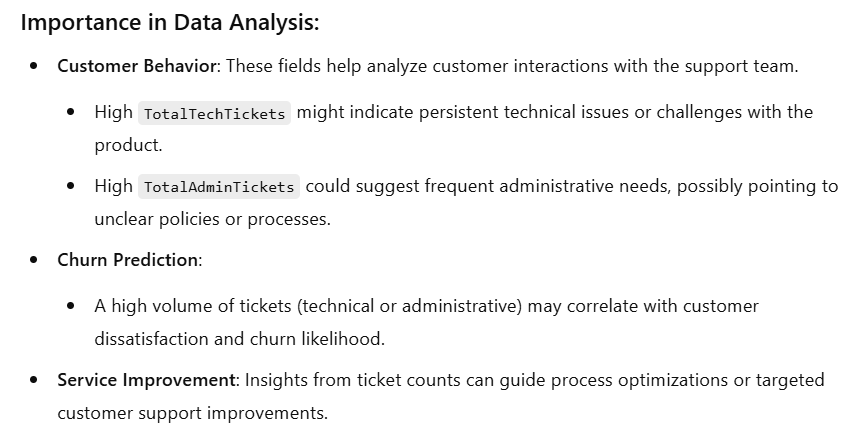

In [25]:
result2 = app.sql('''
                      select sum(numTechTickets) as `Total_no_of_technical_tickets`,
                      sum(numAdminTickets) as `Total_no_of_administrative_tickets`
                      from customers
                  ''')
result2.show()

+-----------------------------+----------------------------------+
|Total_no_of_technical_tickets|Total_no_of_administrative_tickets|
+-----------------------------+----------------------------------+
|                         2955|                              3621|
+-----------------------------+----------------------------------+



In [28]:
result3 = app.sql('''
                      select round(sum(MonthlyCharges), 2)as `Total_Monthly_charges` , 
                      round(sum(TotalCharges), 2)as `Total_Yearly_charges`
                      from customers
                  ''')
result3.show()

+---------------------+--------------------+
|Total_Monthly_charges|Total_Yearly_charges|
+---------------------+--------------------+
|             455661.0|        1.60561687E7|
+---------------------+--------------------+



In [77]:
result4 = app.sql('''
                      with cte1 as
                      (
                      select gender, count(customerID) as `Total_customers`
                      from customers
                      group by gender
                      )
                      , cte2 as
                      (
                      select gender, count(customerID) as `churned_customers`
                      from customers
                      where Churn = 'Yes'
                      group by gender
                      )
                      select t1.gender, t1.Total_customers, t2.churned_customers, (t1.Total_customers - t2.churned_customers) as `Retained_customers`
                      from (cte1 as t1) inner join (cte2 as t2)
                      on t1.gender = t2.gender
                  ''')
result4.show()

+------+---------------+-----------------+------------------+
|gender|Total_customers|churned_customers|Retained_customers|
+------+---------------+-----------------+------------------+
|Female|           3483|              939|              2544|
|  Male|           3549|              930|              2619|
+------+---------------+-----------------+------------------+



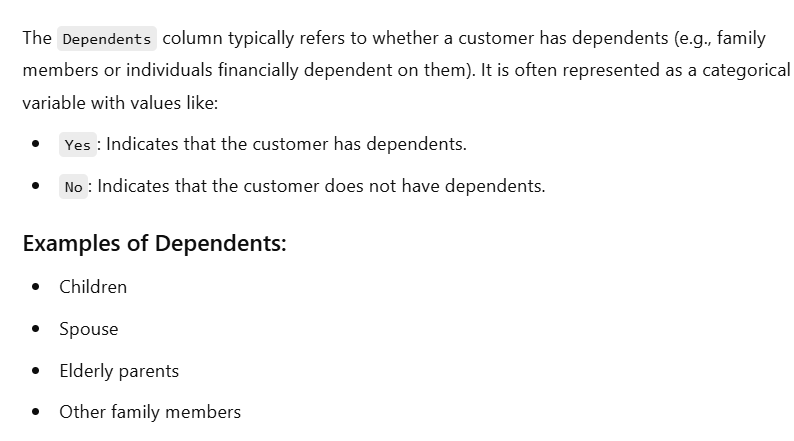

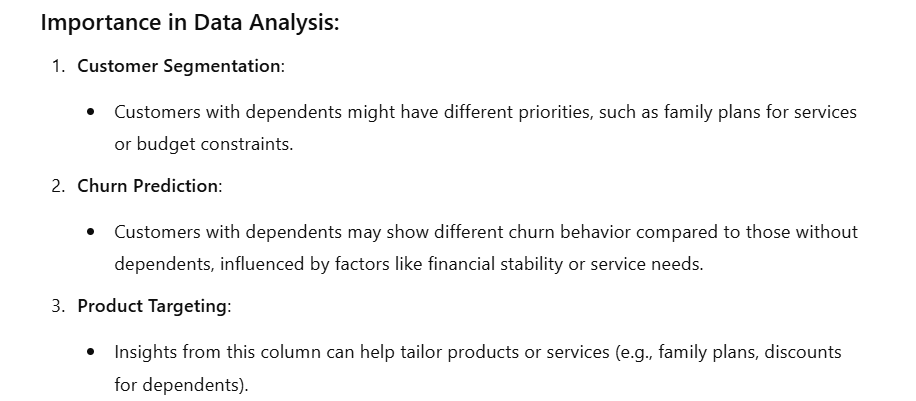

In [34]:
result5 = app.sql('''
                      select count(customerID) as `Total_customers`,
                      (select count(customerID) from customers where Dependents = 'Yes') as `Total_dependent_customers`,
                      (select count(customerID) from customers where SeniorCitizen = 1) as `Total_Senio_citizens`,
                      (select count(customerID) from customers where Partner = 'Yes') as `Total_maried_customers`
                      from customers
                  ''')
result5.show()

+---------------+-------------------------+--------------------+----------------------+
|Total_customers|Total_dependent_customers|Total_Senio_citizens|Total_maried_customers|
+---------------+-------------------------+--------------------+----------------------+
|           7032|                     2099|                1142|                  3393|
+---------------+-------------------------+--------------------+----------------------+



In [39]:
result6 = app.sql('''
                      with cte as
                      (
                      select count(customerID) as `Total_customers`,
                      (select count(customerID) from customers where Dependents = 'Yes') as `Total_dependent_customers`,
                      (select count(customerID) from customers where SeniorCitizen = 1) as `Total_Senior_citizens`,
                      (select count(customerID) from customers where Partner = 'Yes') as `Total_maried_customers`
                      from customers
                      )
                      select Total_customers,
                      round((Total_dependent_customers / Total_customers)*100 , 3) as `%_of_dependent_customers`,
                      round((Total_senior_citizens / Total_customers)*100 , 3) as `%_of_senior_citizens`,
                      round((Total_maried_customers / Total_customers)*100 , 3) as `%_of_partners`
                      from cte
                  ''')
result6.show()

+---------------+------------------------+--------------------+-------------+
|Total_customers|%_of_dependent_customers|%_of_senior_citizens|%_of_partners|
+---------------+------------------------+--------------------+-------------+
|           7032|                  29.849|               16.24|       48.251|
+---------------+------------------------+--------------------+-------------+



In [78]:
result7 = app.sql('''
                      with cte1 as
                      (
                      select Contract, count(customerID) as `Total_customers`
                      from customers
                      group by Contract
                      )
                      , cte2 as
                      (
                      select Contract, count(customerID) as `churned_customers`
                      from customers
                      where Churn = 'Yes'
                      group by Contract
                      )
                      select t1.Contract, t1.Total_customers, t2.churned_customers, (t1.Total_customers - t2.churned_customers) as `Retained_customers`
                      from (cte1 as t1) inner join (cte2 as t2)
                      on t1.Contract = t2.Contract
                  ''')
result7.show()

+--------------+---------------+-----------------+------------------+
|      Contract|Total_customers|churned_customers|Retained_customers|
+--------------+---------------+-----------------+------------------+
|Month-to-month|           3875|             1655|              2220|
|      One year|           1472|              166|              1306|
|      Two year|           1685|               48|              1637|
+--------------+---------------+-----------------+------------------+



In [46]:
result8 = app.sql('''
                      select Loyality as `how_long_customer_with_us`, count(customerID) as `Total_no_of_customers`
                      from customers
                      group by Loyality
                      order by Loyality ASC
                  ''')
result8.show()

+-------------------------+---------------------+
|how_long_customer_with_us|Total_no_of_customers|
+-------------------------+---------------------+
|                 < 1 year|                 2058|
|                < 2 years|                 1047|
|                < 3 years|                  876|
|                < 4 years|                  748|
|                < 5 years|                  820|
|                < 6 years|                 1483|
+-------------------------+---------------------+



In [81]:
result8 = app.sql('''
                      with cte1 as
                      (
                      select Loyality, count(customerID) as `Total_customers`
                      from customers
                      group by Loyality
                      )
                      , cte2 as
                      (
                      select Loyality, count(customerID) as `churned_customers`
                      from customers
                      where Churn = 'Yes'
                      group by Loyality
                      )
                      select t1.Loyality, t1.Total_customers, t2.churned_customers, (t1.Total_customers - t2.churned_customers) as `Retained_customers`
                      from (cte1 as t1) inner join (cte2 as t2)
                      on t1.Loyality = t2.Loyality
                      order by t1.Loyality asc
                  ''')
result8.show()

+---------+---------------+-----------------+------------------+
| Loyality|Total_customers|churned_customers|Retained_customers|
+---------+---------------+-----------------+------------------+
| < 1 year|           2058|              999|              1059|
|< 2 years|           1047|              309|               738|
|< 3 years|            876|              193|               683|
|< 4 years|            748|              146|               602|
|< 5 years|            820|              123|               697|
|< 6 years|           1483|               99|              1384|
+---------+---------------+-----------------+------------------+



In [82]:
result9 = app.sql('''
                    select 
                    (select count(customerID) from customers where InternetService in('DSL', 'Fiber optic')) as `#_of_customers_Signed_InternetService`,
                    (select count(customerID) from customers where OnlineSecurity = 'Yes') as `#_of_customers_Signed_OnlineSecurityService`,
                    (select count(customerID) from customers where OnlineBackup = 'Yes') as `#_of_customers_Signed_OnlineBackupService`
                    
                ''')
result9.show()

+-------------------------------------+-------------------------------------------+-----------------------------------------+
|#_of_customers_Signed_InternetService|#_of_customers_Signed_OnlineSecurityService|#_of_customers_Signed_OnlineBackupService|
+-------------------------------------+-------------------------------------------+-----------------------------------------+
|                                 5512|                                       2015|                                     2425|
+-------------------------------------+-------------------------------------------+-----------------------------------------+



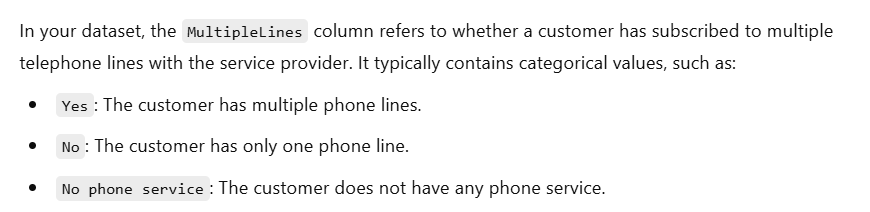

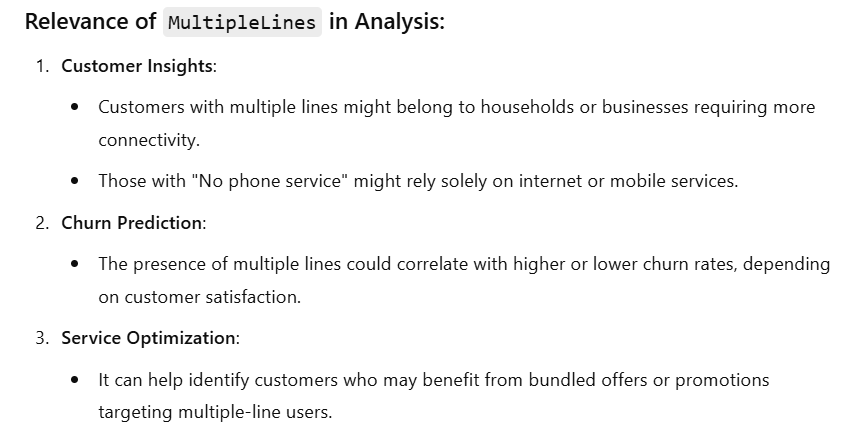

In [83]:
result10 = app.sql('''
                    select 
                    (select count(customerID) from customers where PhoneService = 'Yes') as `#_of_customers_Signed_PhoneService`,
                    (select count(customerID) from customers where MultipleLines = 'Yes') as `#_of_customers_Signed_MultipleLinesService`,
                    (select count(customerID) from customers where MultipleLines = 'NO') as `#_of_customers_Signed_No-MultipleLinesService`
                    
                ''')
result10.show()

+----------------------------------+------------------------------------------+---------------------------------------------+
|#_of_customers_Signed_PhoneService|#_of_customers_Signed_MultipleLinesService|#_of_customers_Signed_No-MultipleLinesService|
+----------------------------------+------------------------------------------+---------------------------------------------+
|                              6352|                                      2967|                                         3385|
+----------------------------------+------------------------------------------+---------------------------------------------+



In [84]:
result11 = app.sql('''
                    select 
                    (select count(customerID) from customers where StreamingMovies = 'Yes') as `#_of_customers_Signed_StreamingMoviesService`,
                    (select count(customerID) from customers where StreamingTV= 'Yes') as `#_of_customers_Signed_StreamingTVService`,
                    (select count(customerID) from customers where TechSupport= 'Yes') as `#_Signed_TechSupportService`,
                    (select count(customerID) from customers where DeviceProtection= 'Yes') as `#_Signed_DeviceProtectionService`
                    
                ''')
result11.show()

+--------------------------------------------+----------------------------------------+---------------------------+--------------------------------+
|#_of_customers_Signed_StreamingMoviesService|#_of_customers_Signed_StreamingTVService|#_Signed_TechSupportService|#_Signed_DeviceProtectionService|
+--------------------------------------------+----------------------------------------+---------------------------+--------------------------------+
|                                        2731|                                    2703|                       2040|                            2418|
+--------------------------------------------+----------------------------------------+---------------------------+--------------------------------+



In [64]:
result12 = app.sql('''
                      select PaperlessBilling, count(customerID) as `Total_customers`
                      from customers
                      group by PaperlessBilling
                  ''')
result12.show()

+----------------+---------------+
|PaperlessBilling|Total_customers|
+----------------+---------------+
|              No|           2864|
|             Yes|           4168|
+----------------+---------------+



In [85]:
result13 = app.sql('''
                      select PaymentMethod, count(customerID) as `Total_customers`
                      from customers
                      group by PaymentMethod
                  ''')
result13.show()

+--------------------+---------------+
|       PaymentMethod|Total_customers|
+--------------------+---------------+
|Credit card (auto...|           1521|
|        Mailed check|           1604|
|Bank transfer (au...|           1542|
|    Electronic check|           2365|
+--------------------+---------------+

